## Import Libraries
Here, we import the necessary libraries for data processing and visualization. We also set some data formatting rules to get rid of long decimals/floats.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

pd.options.display.float_format = "{:.3f}".format
np.set_printoptions(formatter={'float': lambda x: '{:.3f}'.format(x)})

## Set hyperparameters
Include list of phonemes + silence. Usually keep SIZE and STEP the same, but can have STEP < SIZE to have overlap in training exmaples.


In [ ]:
# X_train.shape = [N, CHANNELS, SIZE]
# Filename format - X_PHONEMES_N_CHANNELS_SIZE_STEP.npy
PHONEMES = ['_', 'B', 'D', 'F', 'G', 'HH', 'JH', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'W', 'Y', 'Z', 'CH', 'SH', 'NG', 'DH', 'TH', 'ZH', 'WH', 'AA', 'AI(R)', 'I(R)', 'A(R)', 'ER', 'EY', 'IY', 'AY', 'OW', 'UW', 'AE', 'EH', 'IH', 'AO', 'AH', 'UH', 'OO', 'AW', 'OY']
CHANNELS = 4
SIZE = 5
STEP = 5

## Define plot_all_channels Function
Define a function `plot_all_channels` that takes a DataFrame and a title as inputs, and creates a figure with subplots for each channel.

In [ ]:
def plot_all_channels(df, title, tick_gap = None, start = None, end = None): # Create a figure and subplots for each channel
  fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True)

  if start and end:
    for i, channel in enumerate(column_names):
        if channel != 'TIMESTAMP':
          axes[i].plot(df[channel][start:end], label=channel)
          axes[i].set_ylabel(channel)
          axes[i].legend(loc="upper left")
  else:
    for i, channel in enumerate(column_names):
      if channel != 'TIMESTAMP':
        axes[i].plot(df[channel], label=channel)
        axes[i].set_ylabel(channel)
        axes[i].legend(loc="upper left")

  if tick_gap and start and end:
    plt.xticks(list(range(start, end, tick_gap)))
  elif tick_gap:
    plt.xticks(list(range(0, len(df), tick_gap)))

  # Set the x-axis label and title for the entire figure
  plt.xlabel("Sample Index")
  plt.suptitle(title)

  # Display the plot
  plt.show()

## Load Data
Load the CSV data into a Pandas dataframe and get some information on its shape and columns.


In [ ]:
# Update the file path below with the path to your CSV file
csv_file_path = "data_all44.csv"

# Read the CSV data into a Pandas DataFrame
df_og = pd.read_csv(csv_file_path, skiprows=4)

print(f"df_og.shape:{df_og.shape}")
print(f"df_og.columns:{df_og.columns}")

df_og.shape:(234467, 25)
df_og.columns:Index(['Sample Index', ' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2',
       ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6',
       ' EXG Channel 7', ' Accel Channel 0', ' Accel Channel 1',
       ' Accel Channel 2', ' Other', ' Other.1', ' Other.2', ' Other.3',
       ' Other.4', ' Other.5', ' Other.6', ' Analog Channel 0',
       ' Analog Channel 1', ' Analog Channel 2', ' Timestamp', ' Other.7',
       ' Timestamp (Formatted)'],
      dtype='object')


## Preprocess Data
Filter to only keep relevant columns, replace timestamps with a 4ms incerment since we know that's the recording frequency.

In [ ]:
# Select the columns from index 1 to 5 and column index 22, then concatenate the resulting DataFrames horizontally (axis=1)
df_filtered = pd.concat([df_og.iloc[:, 1:6], df_og.iloc[:, 22]], axis=1)
# df = df_og

# Assign new column names (DLI, OOS, OOI, PLA, BUTTON, TIMESTAMP)
column_names = ['DLI', 'OOS', 'OOI', 'PLA', 'BUTTON', 'TIMESTAMP']
df_filtered.columns = column_names

df_filtered['TIMESTAMP'] = [i*4 for i in range(0, len(df_filtered))]

df_filtered

,DLI,OOS,OOI,PLA,BUTTON,TIMESTAMP
0,-22754.791,-11024.417,12148.799,-29197.994,-637.829,0
1,-22749.963,-11026.026,12146.653,-29196.921,-636.756,4
2,0.000,0.000,0.000,0.000,0.000,8
3,-21561.208,-12014.152,11625.232,-30386.213,-636.220,12
4,-21560.135,-12016.298,11625.768,-30385.677,-636.220,16
...,...,...,...,...,...,...
234462,3829.658,-20496.907,1507.938,-16405.465,-636.756,937848
234463,3826.440,-20490.470,1482.189,-16391.518,-636.756,937852
234464,3820.003,-20486.715,1492.381,-16391.518,-636.220,937856
234465,3818.393,-20492.079,1482.189,-16404.392,-638.902,937860


## Plot Raw EMG Channels
Plot the raw EMG channels using the `plot_all_channels` function.

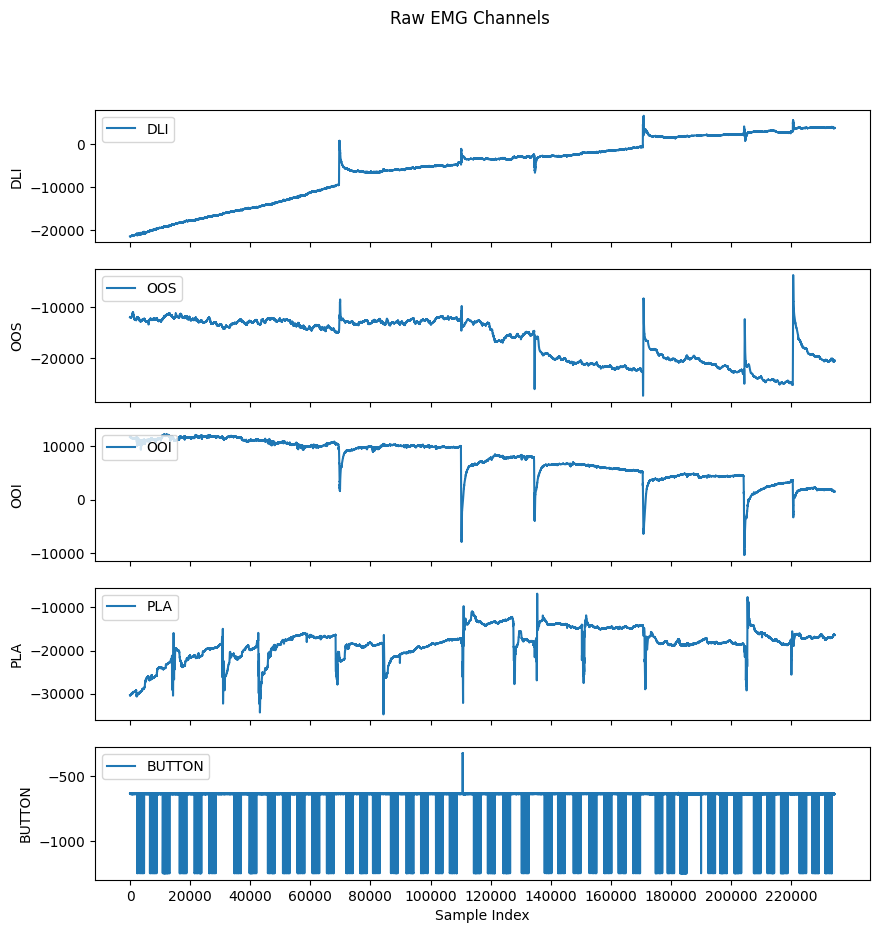

In [ ]:
# Remove first 10 rows because of bad data
CUTOFF = 10
df = df_filtered.iloc[CUTOFF:]

df = df.reset_index(drop=True)

# Plot
plot_all_channels(df, "Raw EMG Channels", tick_gap = 20000)

## Outlier Removal and Data Normalization
Manually cut out outliers, and normalize the data using Min-Max normalization, round "BUTTON" values to 0 or 1, flip them so they're the right way around, and create a new DataFrame `df_normalized`.

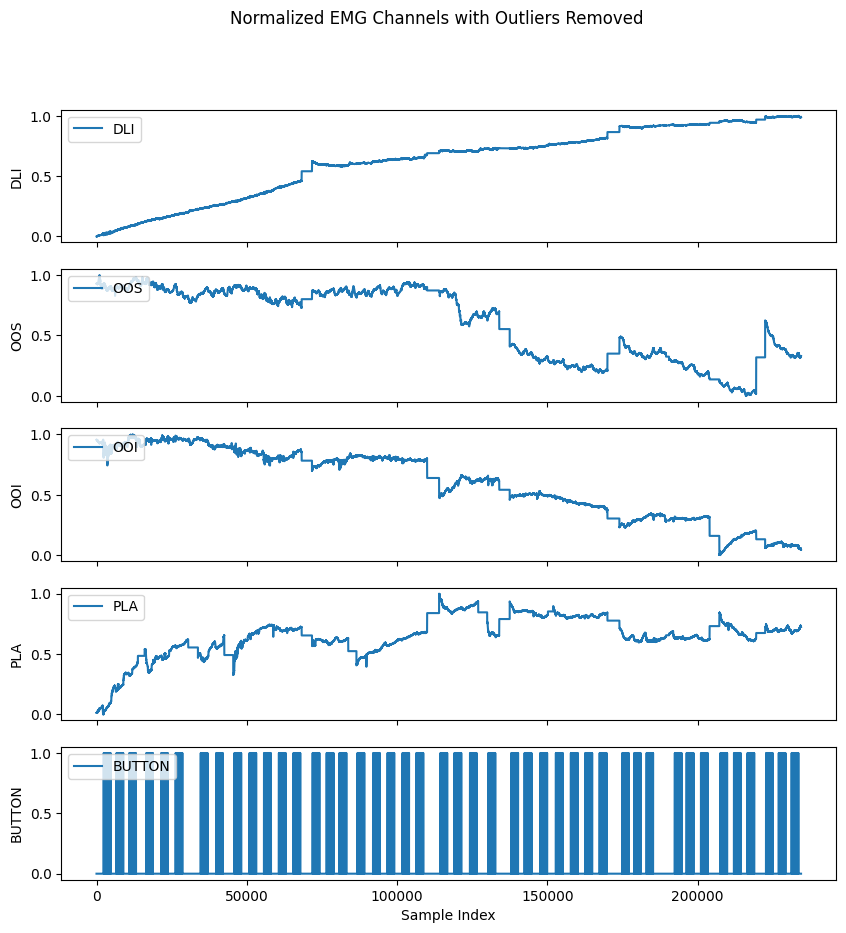

In [ ]:
# Backup the "TIMESTAMP" column before removing outliers and normalization
timestamp_col = df["TIMESTAMP"].copy()

LEFT_PAD = 0
RIGHT_PAD = 0
AVG_PAD = 200

# Manually remove outliers by replacing with mean of surrounding values
df['PLA'].iloc[13750-LEFT_PAD:16000+RIGHT_PAD] = df['PLA'].iloc[np.r_[13750-AVG_PAD:13750, 16000:16000+AVG_PAD]].mean()
df['PLA'].iloc[30500-LEFT_PAD:33750+RIGHT_PAD] = df['PLA'].iloc[np.r_[30500-AVG_PAD:30500, 33750:33750+AVG_PAD]].mean()
df['PLA'].iloc[42500-LEFT_PAD:45500+RIGHT_PAD] = df['PLA'].iloc[np.r_[42500-AVG_PAD:42500, 45500:45500+AVG_PAD]].mean()
df.iloc[68250-LEFT_PAD:71700+RIGHT_PAD] = df.iloc[np.r_[68250-AVG_PAD:68250, 71700:71700+AVG_PAD]].mean()
df['PLA'].iloc[83750-LEFT_PAD:86500+RIGHT_PAD] = df['PLA'].iloc[np.r_[83750-AVG_PAD:83750, 86500:86500+AVG_PAD]].mean()
df.iloc[110000-LEFT_PAD:114000+RIGHT_PAD] = df.iloc[np.r_[110000-AVG_PAD:110000, 114000:114000+AVG_PAD]].mean()
df['PLA'].iloc[127000-LEFT_PAD:130000+RIGHT_PAD] = df['PLA'].iloc[np.r_[127000-AVG_PAD:127000, 130000:130000+AVG_PAD]].mean()
df.iloc[134000-LEFT_PAD:137500+RIGHT_PAD] = df.iloc[np.r_[134000-AVG_PAD:134000, 137500:137500+AVG_PAD]].mean()
df['PLA'].iloc[150200-LEFT_PAD:152000+RIGHT_PAD] = df['PLA'].iloc[np.r_[150200-AVG_PAD:150200, 152000:152000+AVG_PAD]].mean()
df.iloc[170000-LEFT_PAD:174000+RIGHT_PAD] = df.iloc[np.r_[170000-AVG_PAD:170000, 174000:174000+AVG_PAD]].mean()
df.iloc[189500-LEFT_PAD:190500+RIGHT_PAD] = df.iloc[np.r_[189500-AVG_PAD:189500, 190500:190500+AVG_PAD]].mean()
df.iloc[204000-LEFT_PAD:207250+RIGHT_PAD] = df.iloc[np.r_[204000-AVG_PAD:204000, 207250:207250+AVG_PAD]].mean()
df.iloc[219500-LEFT_PAD:222500+RIGHT_PAD] = df.iloc[np.r_[219500-AVG_PAD:219500, 222500:222500+AVG_PAD]].mean()

# Drop the "TIMESTAMP" column before normalizing
df_no_timestamp = df.drop("TIMESTAMP", axis=1)

# Normalize the data using Min-Max normalization
df_normalized = (df_no_timestamp - df_no_timestamp.min()) / (df_no_timestamp.max() - df_no_timestamp.min())

# Round "BUTTON" values to 0 or 1
df_normalized["BUTTON"] = df_normalized["BUTTON"].round()

# Flip values for convenience
df_normalized['BUTTON'] = df_normalized['BUTTON'].apply(lambda x: 1 if x == 0 else 0)

# Re-insert the "TiTIMESTAMPmestamp" column
df_normalized.insert(0, "TIMESTAMP", timestamp_col)

# Plot
plot_all_channels(df_normalized, "Normalized EMG Channels with Outliers Removed")

## Define plot_rolling_channel_4 and segment_stats Functions
Define two functions: `plot_rolling_channel_4` for plotting the rolling maximum of "BUTTON" with different ranges, and `segment_stats` for calculating statistics about the segments.

In [ ]:
def plot_rolling_channel_4(title, tick_gap = 2500, start=None, end=None, df = df_normalized):
  # # Do proper data cut based on arguments
  if start is None:
    start = 0
  if end is None:
    end = len(df)

  # Plot the original data and the rolling mean on a number line
  plt.figure(figsize=(16, 4))
  # plt.plot(df.index, df['EXG Channel 4'], label='Original Data', alpha=0.5)
  plt.plot(df[start:end].index, df['rolling_max'][start:end], linewidth=1)
  plt.xlabel('Index')
  plt.ylabel('Activation')

  plt.xticks(list(range(start, end, tick_gap)))

  plt.title(title)
  plt.show()

def segment_stats(df, segments):
  # Calculate statistics about the list of segments
  num_segments = len(segments)  # Number of segments
  segment_lengths = [end - start for start, end in segments]  # Lengths of each segment in terms of indices

  # Calculate the average segment length
  average_length = np.around(np.mean(segment_lengths), 2)

  # Calculate the minimum and maximum segment length
  min_length = np.min(segment_lengths)
  max_length = np.max(segment_lengths)

  # Calculate the segment lengths in terms of time (milliseconds) using the "TIMESTAMP" column
  segment_lengths_ms = [(df.loc[end, 'TIMESTAMP'] - df.loc[start, 'TIMESTAMP']) for start, end in segments]

  # Calculate the mean, min, and max segment lengths in milliseconds
  mean_length_ms = np.around(np.mean(segment_lengths_ms), 2)
  min_length_ms = np.around(np.min(segment_lengths_ms), 2)
  max_length_ms = np.around(np.max(segment_lengths_ms), 2)

  # Calculate the standard deviation of segment lengths
  sd_length = np.around(np.std(segment_lengths), 2)

  # Calculate the standard deviation of segment_lengths_ms
  sd_length_ms = np.around(np.std(segment_lengths_ms), 2)

  # Print the statistics
  print(f"\nSegments: {segments}")
  print(f"Number of segments: {num_segments}")
  print(f"Average segment length: {average_length} values")
  print(f"Minimum segment length: {min_length} values")
  print(f"Maximum segment length: {max_length} values")
  print(f"Standard Deviation of segment length: {sd_length} values")
  print(f"Average segment length (ms): {mean_length_ms} ms")
  print(f"Minimum segment length (ms): {min_length_ms} ms")
  print(f"Maximum segment length (ms): {max_length_ms} ms")
  print(f"Standard Deviation of segment length (ms): {sd_length_ms} ms")

## Add Rolling Max Column (Smooth Out Data)
Add a new column to the DataFrame `df_normalized` for the rolling maximum of "BUTTON" with a window size of rolling_window_size.

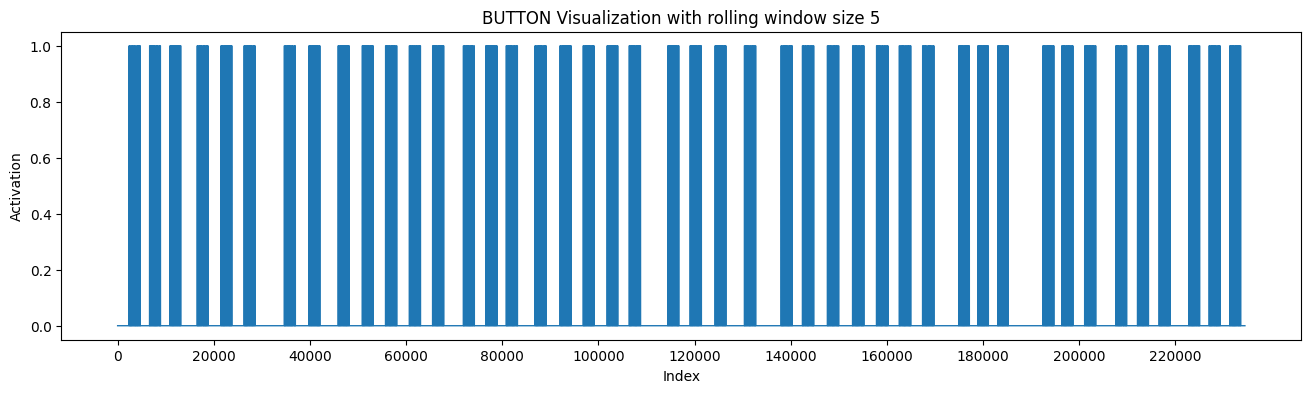

In [ ]:
rolling_window_size = 5

# Make rolling max column
df_normalized['rolling_max'] = df_normalized['BUTTON'].rolling(window=rolling_window_size, center=True).max()

# Plot
plot_rolling_channel_4(f"BUTTON Visualization with rolling window size {rolling_window_size}", tick_gap = 20000)

## Identify Segments
Identify the start and end indices of segments with 1s in the rolling maximum of "BUTTON".

In [ ]:
# Add a new column to the dataframe to identify the change in segments between 0s and 1s
df_normalized['segment_change'] = df_normalized['rolling_max'].diff()

# Identify the start and end indices of the segments with 1s
start_indices = df_normalized[df_normalized['segment_change'] == 1].index.tolist()
end_indices = df_normalized[df_normalized['segment_change'] == -1].index.tolist()

# If the first segment starts with 1s, add the starting index to the list
first_index = df_normalized.index[0]  # Get the first index of the dataframe
if df_normalized.loc[first_index, 'rolling_max'] == 1:
    start_indices.insert(0, first_index)

# If the last segment ends with 1s, add the last index to the list
last_index = df_normalized.index[-1]  # Get the last index of the dataframe
if df_normalized.loc[last_index, 'rolling_max'] == 1:
    end_indices.append(last_index)

# Combine the start and end indices into pairs
segments = list(zip(start_indices, end_indices))

# Filter out small segments
# segments = [(start, end) for start, end in segments if end - start >= 20]

print(f"segments: {segments}")
print(f"len(segments): {len(segments)}")

segments: [(2380, 2410), (2630, 2659), (2892, 2925), (3148, 3180), (3410, 3436), (3661, 3696), (3956, 3987), (4172, 4206), (4419, 4452), (4660, 4692), (6635, 6671), (6875, 6908), (7119, 7149), (7366, 7396), (7606, 7633), (7849, 7880), (8095, 8126), (8343, 8374), (8627, 8658), (8857, 8891), (10881, 10934), (11123, 11187), (11371, 11420), (11605, 11657), (11845, 11898), (12089, 12135), (12325, 12376), (12554, 12601), (12794, 12846), (13061, 13120), (16548, 16581), (16789, 16824), (17038, 17073), (17273, 17305), (17518, 17549), (17796, 17835), (17998, 18036), (18238, 18272), (18495, 18530), (18747, 18784), (21486, 21537), (21721, 21760), (21968, 22010), (22219, 22263), (22469, 22513), (22709, 22748), (22958, 23000), (23217, 23262), (23451, 23498), (23693, 23744), (26303, 26343), (26553, 26585), (26793, 26824), (27032, 27069), (27290, 27328), (27526, 27561), (27769, 27803), (28026, 28061), (28275, 28318), (28530, 28568), (34668, 34700), (34919, 34955), (35185, 35218), (35419, 35454), (3565

## Seperate Segments
Seperate segments into seperate phoneme groupings.

In [ ]:
segment_dict = {key: segments[i:i+10] for i, key in zip(range(0, len(segments), 10), PHONEMES[1:])}

print(f"Total phonemes - len(segment_dict): {len(segment_dict)}")
print(f"Recordings per phoneme: {[len(segment_dict[x]) for x in PHONEMES[1:]]}")

Total phonemes - len(segment_dict): 44
Recordings per phoneme: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


## Plot and Calculate Segment Statistics
Plot and analyze different segments of the data using the `plot_rolling_channel_4` and `segment_stats` functions.

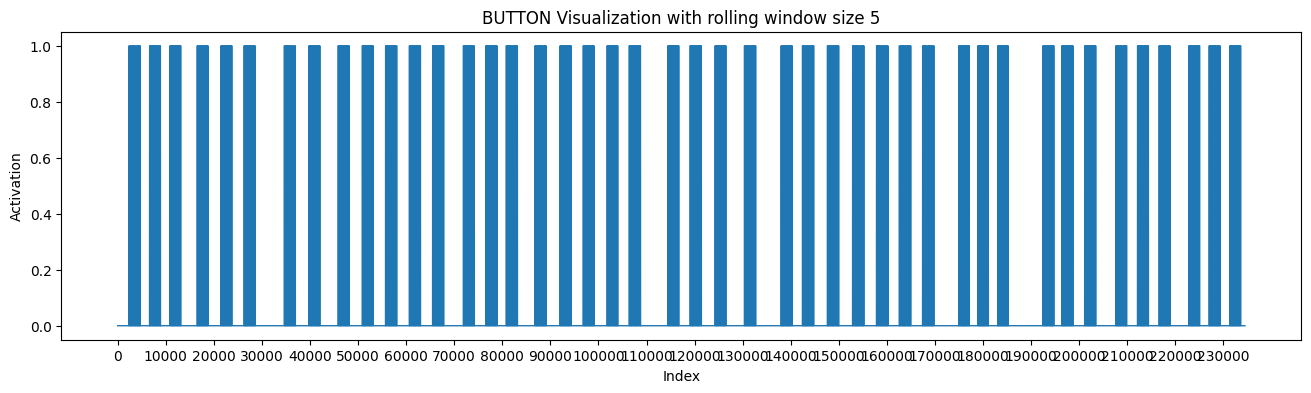


Segments: [(2380, 2410), (2630, 2659), (2892, 2925), (3148, 3180), (3410, 3436), (3661, 3696), (3956, 3987), (4172, 4206), (4419, 4452), (4660, 4692), (6635, 6671), (6875, 6908), (7119, 7149), (7366, 7396), (7606, 7633), (7849, 7880), (8095, 8126), (8343, 8374), (8627, 8658), (8857, 8891), (10881, 10934), (11123, 11187), (11371, 11420), (11605, 11657), (11845, 11898), (12089, 12135), (12325, 12376), (12554, 12601), (12794, 12846), (13061, 13120), (16548, 16581), (16789, 16824), (17038, 17073), (17273, 17305), (17518, 17549), (17796, 17835), (17998, 18036), (18238, 18272), (18495, 18530), (18747, 18784), (21486, 21537), (21721, 21760), (21968, 22010), (22219, 22263), (22469, 22513), (22709, 22748), (22958, 23000), (23217, 23262), (23451, 23498), (23693, 23744), (26303, 26343), (26553, 26585), (26793, 26824), (27032, 27069), (27290, 27328), (27526, 27561), (27769, 27803), (28026, 28061), (28275, 28318), (28530, 28568), (34668, 34700), (34919, 34955), (35185, 35218), (35419, 35454), (356

In [ ]:
plot_rolling_channel_4(f"BUTTON Visualization with rolling window size {rolling_window_size}", tick_gap = 10000)
segment_stats(df_normalized, segments)

# Clean Dataframe
Remove unneeded columns.

In [ ]:
df_final = df_normalized.drop(['TIMESTAMP', 'BUTTON', 'rolling_max', 'segment_change'], axis=1)
df_final.head()

,DLI,OOS,OOI,PLA
0,0.000,0.929,0.956,0.012
1,0.000,0.928,0.955,0.012
2,0.000,0.929,0.955,0.012
3,0.000,0.929,0.955,0.012
4,0.000,0.929,0.955,0.012


# Create Silent Segments
Pick an area with no recording/EMG activation, and generate even sections as silence class training examples.

In [ ]:
NUM_SILENT_SEGMENTS = int (50 / (SIZE / 5)) * 2

def generate_even_segments(segment_size, segment_count, start_index, end_index):
    segments = []
    total_length = segment_size * segment_count

    # Calculate the range between start_index and end_index
    max_range = end_index - start_index

    # Calculate the overlap or gap between segments
    overlap_gap = (total_length - max_range) // (segment_count - 1) if segment_count > 1 else 0

    for i in range(segment_count):
        start_index_segment = start_index + i * (segment_size - overlap_gap)  # Calculate start_index for each segment based on overlap or gap
        end_index_segment = start_index_segment + segment_size

        segments.append((start_index_segment, end_index_segment))

    return segments

# Between 186000 and 198000
segments_silence = generate_even_segments(SIZE, NUM_SILENT_SEGMENTS, 186000, 198000)
len(segments_silence)

100

## Segment Data
Split the actual dataframes into the segment chunks, store in dictionary.

In [ ]:
# Create recording arrays from df and array of (start, end) segments
def segment_data(df, segments):
  data_segments = []
  for start, end in segments:
    segment = df.iloc[start:end].to_numpy()
    data_segments.append(segment)
  return data_segments

data_segments = segment_data(df_final, segments)

data_segments_silence = segment_data(df_final, segments_silence)

data_segments_dict = dict(segment_dict)

total = 0
for key in segment_dict.keys():
  segs_num = len(segment_dict[key])

  data_segments_dict[key] = data_segments[total:total+segs_num]

  total += segs_num

print(f"len(data_segments_dict): {len(data_segments_dict)}")

len(data_segments_dict): 44


## Generate Training Examples/Labels
Using a sliding window technique, create multiple training examples from each segment, concatenate to create X_train, then create appropriate y_train array.


In [ ]:
def generate_training_examples(data_segments, SIZE, STEP):
  training_examples = []

  for segment in data_segments:
    start_index = 0
    end_index = start_index + SIZE

    while end_index <= len(segment):
      example = segment[start_index:end_index]
      training_examples.append(example)

      start_index += STEP
      end_index += STEP

  return training_examples

# Generate training examples for each phoneme and silence
train_dict = dict([(key, generate_training_examples(data_segments_dict[key], SIZE, STEP)) for key in segment_dict.keys()])

train_silence = generate_training_examples(data_segments_silence, SIZE, STEP)
print(f"# _: {len(train_silence)}")

for key in train_dict.keys():
  print(f"# {key}: {len(train_dict[key])}")

# Concatenate training arrays
def concatenate_lists(dictionary):
    result = []  # Create empty list to store the concatenated lists

    # Loop over the values of the dictionary
    for value_list in dictionary.values():
        # Extend the result list instead of appending to flatten the list of lists
        result.extend(value_list)

    return result  # Return the concatenated lists

X_train = train_silence + concatenate_lists(train_dict)
X_train = np.transpose(np.array(X_train), (0, 2, 1))

print(f"\nX_train.shape: {X_train.shape} - {X_train.shape[0]} training examples, {X_train.shape[1]} channels (muscle groups) per example, each {X_train.shape[2]} timesteps long")

# Generate training labels for each phoneme and silence
y_train_silence = np.full(len(train_silence), 0)

# Generate the labels for the keys in train_dict using a dictionary comprehension
# The keys need to be integers, so use enumerate() to assign an index (starting from 1)
y_train_dict = {key: np.full(len(train_dict[key]), i + 1) for i, key in enumerate(train_dict.keys())}

# Concatenate the labels
def concatenate_labels(labels_dict, first_label_array):
    result = first_label_array.tolist()  # Convert the first_label_array to a list

    # Loop over the values (arrays) of the labels_dict
    for label_array in labels_dict.values():
        # Extend the result list with the elements of the label_array converted to list
        result.extend(label_array.tolist())

    return np.array(result)  # Convert the result list to an array and return it

y_train = concatenate_labels(y_train_dict, y_train_silence)

print(f"y_train.shape: {y_train.shape} - {y_train.shape[0]} training labels")

# _: 100
# B: 59
# D: 60
# F: 100
# G: 66
# HH: 84
# JH: 69
# K: 62
# L: 89
# M: 91
# N: 90
# P: 70
# R: 59
# S: 81
# T: 54
# V: 94
# W: 66
# Y: 57
# Z: 95
# CH: 64
# SH: 70
# NG: 89
# DH: 94
# TH: 103
# ZH: 99
# WH: 65
# AA: 59
# AI(R): 55
# I(R): 59
# A(R): 68
# ER: 70
# EY: 59
# IY: 67
# AY: 65
# OW: 65
# UW: 56
# AE: 64
# EH: 62
# IH: 60
# AO: 62
# AH: 62
# UH: 63
# OO: 71
# AW: 64
# OY: 59

X_train.shape: (3220, 4, 5) - 3220 training examples, 4 channels (muscle groups) per example, each 5 timesteps long
y_train.shape: (3220,) - 3220 training labels


## Create Filename
Set filename based on hyperparameters.

In [ ]:
# X_train.shape = [N, CHANNELS, SIZE]
# Filename format - _PHONEMES_N_CHANNELS_SIZE_STEP.npy

N = len(X_train)
filename = f"_all44_{N}_{CHANNELS}_{SIZE}_{STEP}.npy"
print(filename)

_all44_3220_4_5_5.npy


## Save Files

In [ ]:
np.save(f"./X{filename}", X_train)
np.save(f"./y{filename}", y_train)